In [79]:
import math

from mdptoolbox_wrapper import *
import mdptoolbox
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
book_grid = [[' ',' ',' ',+100],
            [' ','#',' ',-100],
            ['@',' ',' ',' ']]

def run_policy_iteration_from_T(T, gamma):
    mdp = MDPToolBoxWrapper(create_MDP(T, gamma))
    pi = mdptoolbox.mdp.ValueIteration(mdp.transitions, mdp.rewards, mdp.gamma)
    # To use policy iteratiom: pi = mdptoolbox.mdp.PolicyIteration(mdp.transitions, mdp.rewards, mdp.gamma, eval_type=1)
    # NOTE: PolicyIteration doesn't converge with gamma = 1 when eval_type = 1 as it results in singular matrix
    pi.run()
    return pi

def run_policy_iteration(mdp):
    pi = mdptoolbox.mdp.ValueIteration(mdp.transitions, mdp.rewards, mdp.gamma)
    pi.run()
    return pi
    
class GridWorld(object):
    """
    This is a nice approximation for all the complexity of the entire universe 
        –Charles Isbell
    """
    MARKER_WALL = '#'
    MARKER_CURR_STATE = '@'
    MARKER_FREE_SPACE = ' '
    
    def __init__(self, grid, living_reward=-0.01, gamma=0.99, action_noise_dist=[0.1, 0.8, 0.1], silent=True):
        
        """
        Returns a grid world with input specifications. 
        
        Grid spec: '#' walls, '<int>' terminal state, 'S' initial position, ' ' free space
        """
        
        assert(len(grid) != 0 and len(grid[0]) != 0)
        
        self.grid = grid.copy()
        self.width = len(grid[0])
        self.height = len(grid)
        self.living_reward = living_reward
        self.action_noise_dist = action_noise_dist
        self.actions_name = ["North", "East", "South", "West"]
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.curr_state, self.states = self._compute_states(grid)
        self.nA = len(self.actions)
        self.nS = len(self.states)
        # states_to_idx: Maps state feature (dim=K) to its index(0-N) in the self.states list
        # For reverse mapping we can simply use self.states as it gives state features at a given index
        self.states_to_idx = dict(zip(self.states, range(self.nS))) 
        self.mdp_transitions = self.compute_mdp_transitions()
        self.gamma = gamma
        self.mdp = MDPToolBoxWrapper(create_MDP(self.mdp_transitions, self.gamma))
        self.policy_iteration_results = run_policy_iteration(self.mdp)
        
        # Add class attribute for action strings which evaluates to action index
        for i, a_name in enumerate(self.actions_name):
            setattr(type(self), a_name, i)
            
        # For visualization purpose
        self.silent = silent
        if not self.silent: print(self.get_state_representation_2d(self.curr_state))
            
    def _compute_states(self, grid, feature_type='2d_loc'):
        """
        Returns: Computes number of states in the grid world.
        Input: 
            grid: grid description as python 2d array of strings (Ref: book_grid)
        """
        states = []
        for row in range(self.height): #[::-1]: # all rows, reverse order so that 0th state is (0,0)
            for col in range(self.width): # all cols
                
                # State feature is simply (row#, col#)
                state_feat1, state_feat2 = row, col
                # Walls act like obstacles, and bumping into them won't change state (for now)
                if grid[row][col] != self.MARKER_WALL:
                    if grid[row][col] == self.MARKER_CURR_STATE:
                        if feature_type == '2d_loc':
                            init_state = (state_feat1, state_feat2)
                        else:
                            raise ValueError("Not Supported feature_type={}!".format(feature_type))
                    states.append((state_feat1, state_feat2))
        return init_state, states
    
    def _is_terminal(self, s_idx):
        """
        Returns: boolean representing whether a state represented by its index is a terminal
            As per current model, this will be True for grid cells with integer reward value
        """
        r, c = self.states[s_idx]
        return isinstance(self.grid[r][c], int) or isinstance(self.grid[r][c], float)
    
    def reward(self, s_idx):
        r, c = self.states[s_idx]
        if isinstance(self.grid[r][c], int) or isinstance(self.grid[r][c], float):
            return float(self.grid[r][c])
        else:
            return self.living_reward
        
    def stochastic_action(self, a_idx):
        return np.random.choice([a_idx-1, a_idx, (a_idx+1)%self.nA], p=self.action_noise_dist)
    
    def next_states_with_probs(self, s_idx, a_idx):
        """
        Returns: Returns (next states, probabilities next states) for given state and stochastic action
        """
        assert(len(self.action_noise_dist) == 3)
        
        state_primes_to_probs = {}
        r, c = self.states[s_idx]
        for j, noisy_a_idx in enumerate([a_idx-1, a_idx, (a_idx+1)%self.nA]): # hard coded for len(self.action_noise_dist) == 3
            
            dr, dc = self.actions[noisy_a_idx]
            p = self.action_noise_dist[j]
            new_r, new_c = r+dr, c+dc
            if new_r < 0 or new_r >= self.height \
                or new_c < 0 or new_c >= self.width \
                or self.grid[new_r][new_c] == self.MARKER_WALL:
                    new_r, new_c = r, c
                    
            if self.states_to_idx[(new_r, new_c)] in state_primes_to_probs:
                state_primes_to_probs[self.states_to_idx[(new_r, new_c)]] += p
            else:
                state_primes_to_probs[self.states_to_idx[(new_r, new_c)]] = p
            
        return state_primes_to_probs.items()
    
    def compute_mdp_transitions(self):
        """
        Computes and Returns: MDP Transitions T{s}{a} = (p, s_prime, r, done) for all s, a, s_prime
        """
        mdp = {}
        for s_idx in range(self.nS):
        
            mdp[s_idx] = {}
            for a_idx in range(self.nA):
                if self._is_terminal(s_idx):
                    mdp[s_idx][a_idx] = [(1., s_idx, 0., True)]
                else:
                    mdp[s_idx][a_idx] = []
                    for k, (s_prime_idx, next_p) in enumerate(self.next_states_with_probs(s_idx, a_idx)):
                        mdp[s_idx][a_idx].append((next_p, s_prime_idx, self.reward(s_prime_idx), False))
        return mdp
    
    def get_transition_dynamics_T(self):
        """
        Returns: 3D MDP transition dynamics T[s, a, s']
        """
        return self.mdp.transitions.transpose(1,0,2).copy()
    
    def get_optimal_policy(self):
        """
        Returns: Optimal Policy Pi(s) for all s
        """
        return np.asarray(self.policy_iteration_results.policy).copy()
        
    def get_possible_actions(self, s_idx):
        
        if self._is_terminal(s_idx):
            return None
        
        return self.actions.copy()
    
    def get_state_features_matrix(self):
        """
        Returns: State feature matrix of size N x K, N is number of states and K is dimensionality of state features
        """
        return np.asarray(self.states).copy()
    
    def move(self, a_idx):
        """
        Takes stochastic action speified by a_idx in curr_state of the object and modifies curr_state with the resulting state
        """
        s_idx = self.states_to_idx[self.curr_state]
        s_prime_idx = self.act(s_idx, a_idx)
        self.curr_state = self.states[s_prime_idx]
        if not self.silent: print(self.get_state_representation_2d(self.curr_state))

    def act(self, s_idx, a_idx):
        """
        Returns: the next state index from executing stochastic a_idx in s_idx
        """
        a_idx = self.stochastic_action(a_idx)
        s_prime_idx = np.random.choice(range(self.nS), p=self.mdp.transitions[a_idx, s_idx])
        return s_prime_idx
    
    def sample_trajectories(self, M, init_state_idx="random", max_length=100, Pi="optimal", padding=True):
        """
        Samples and returns T trajectories of the form 
            [ [(s0_0, a0_0, r0_0), ..., (s0_T, a0_T, r0_T)], [(s1_0, a1_0, r1_0), ..., (s1_T, a1_T, r1_T)], 
                                                ... [(sM_0, aM_0, rM_0), ..., (sM_T, aM_T, rM_T)]]
        Input:
            M: # of trajectories to be sampled
            init_state_idx: initial state s0, if assigned "random" it'll randomly sample starting state
            max_length: maximum length of the trajectory
            padding: If trajectory (walk over DAG) terminates before encountering max_length states, it'll pad the last (s,a,r)
            Pi: Policy. Mapping of state_idx to action_idx of size N, where N is number of states.
            
        """
        tau_list = []
        
        for _ in range(M):
            tau_list.append(self.sample_trajectory(init_state_idx, max_length, Pi, padding))
        return tau_list
    
    def sample_trajectory(self, init_state_idx="random", max_length=100, Pi="optimal", padding=True):
        """
        Samples a trajectory of the form [(s0, a0, r0), ..., (sT, aT, rT)]
        Input:
            init_state_idx: initial state s0, if assigned "random" it'll randomly sample starting state
            max_length: maximum length of the trajectory
            padding: If trajectory (walk over DAG) terminates before encountering max_length states, it'll pad the last (s,a,r)
            Pi: Policy. Mapping of state_idx to action_idx of size N, where N is number of states.
                Two special values:
                    - "random" will initialize a random policy
                    - "optimal" will use the optimal policy for the given MDP (currently using policy iteration)
        """
        tau = []
        
        if init_state_idx == "random":
            s_idx = np.random.randint(self.nS)
        else:
            s_idx = init_state_idx
            
        if Pi == "random":    
            Pi = np.random.choice(mdp.nA, size=mdp.nS)
        elif Pi == "optimal":
            Pi = self.get_optimal_policy()
        else:
            pass
        
        for i in range(max_length):
            a_idx = Pi[s_idx]
            tau.append((s_idx, a_idx, self.reward(s_idx)))
            if self._is_terminal(s_idx):
                # Reached terminal state, terminate trajectory here
                break
            s_prime_idx = self.act(s_idx, a_idx)
            s_idx = s_prime_idx
        
        if padding:
            for j in range(i, max_length):
                tau.append((s_idx, a_idx, self.reward(s_idx)))
        return tau
    
    def interpret_trajectory(self, tau):
        
        for (s_idx, a_idx, r) in tau:
            print("s:")
            print(self.get_state_representation_2d(self.states[s_idx]))
            print("a: ", self.actions_name[a_idx])
            print("r: ", r) # Note: this is current state reward
    
    def disp_custom_grid(self, state_values, formatting=lambda x: "{:+.3f}".format(x)):
        
        """
        Returns: state_values representation of states
        Input: state_values associated with each state
        """
        self.state_values_dict = {self.states[i]: state_values[i] for i in range(self.nS)}
        
        msg = ''
        cell_filler = "_"
        grid = self.grid
        for r in range(self.height):
            for c in range(self.width):
                if grid[r][c] != self.MARKER_WALL:
                    tt = formatting(self.state_values_dict[(r,c)])
                else: # Values of unreachable states (Walls) are 0
                    tt = formatting(0)
                msg += tt + "\t" #"{txt:{fill}^5s}".format(txt=tt, fill=cell_filler)
            msg += "\n"
        print(msg)
        
    def get_state_representation_2d(self, state):
        
        msg = ''
        cell_filler = "_"
        grid = self.grid
        curr_r, curr_c = state
        for r in range(self.height):
            for c in range(self.width):
                if r == curr_r and c == curr_c:
                    tt = self.MARKER_CURR_STATE
                elif grid[r][c] == self.MARKER_FREE_SPACE\
                    or (grid[r][c] == self.MARKER_CURR_STATE and (r != curr_r or c != curr_c)):
                    tt = cell_filler
                else:
                    if isinstance(grid[r][c], int) or isinstance(grid[r][c], float):
                        tt = "{:+d}".format(grid[r][c])
                    else:
                        tt = grid[r][c]
                msg += "{txt:{fill}^5s}\t".format(txt=tt, fill=cell_filler)
            msg += "\n"
        return msg
    
    def __str__(self):
        return self.get_state_representation_2d(self.curr_state)

In [85]:
gw = GridWorld(book_grid, action_noise_dist=[0.1,0.8,0.1], silent=False)

_____	_____	_____	+100_	
_____	__#__	_____	-100_	
__@__	_____	_____	_____	



In [4]:
gw.move(GridWorld.North)

_____	_____	_____	+100_	
__@__	__#__	_____	-100_	
_____	_____	_____	_____	



In [5]:
print("States (fused into a single grid-bc it's possible to do so here):")
gw.disp_custom_grid(range(gw.nS), formatting=lambda x: str(x))

States (fused into a single grid-bc it's possible to do so here):
0	1	2	3	
4	0	5	6	
7	8	9	10	



In [6]:
print(gw.T.keys())
gw.T[0] # S X A X (P(s'), s', R(s'), Done)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


{0: [(0.9, 0, -0.01, False), (0.1, 1, -0.01, False)],
 1: [(0.1, 0, -0.01, False), (0.8, 1, -0.01, False), (0.1, 4, -0.01, False)],
 2: [(0.1, 1, -0.01, False), (0.8, 4, -0.01, False), (0.1, 0, -0.01, False)],
 3: [(0.1, 4, -0.01, False), (0.9, 0, -0.01, False)]}

In [7]:
# print(gw.mdp.transitions[:, :, :]) # A x S x S'

In [8]:
gw.disp_custom_grid(gw.get_optimal_policy(), lambda x: "{:}".format(gw.actions_name[x]))

East	East	East	North	
North	North	West	North	
North	West	West	South	



## Sampling Trajectories

In [9]:
tau = gw.sample_trajectory(max_length=3)
print(tau)

[(3, 0, 100.0), (3, 0, 100.0), (3, 0, 100.0), (3, 0, 100.0)]


In [10]:
gw.interpret_trajectory(tau)

s:
_____	_____	_____	__@__	
_____	__#__	_____	-100_	
_____	_____	_____	_____	

a:  North
r:  100.0
s:
_____	_____	_____	__@__	
_____	__#__	_____	-100_	
_____	_____	_____	_____	

a:  North
r:  100.0
s:
_____	_____	_____	__@__	
_____	__#__	_____	-100_	
_____	_____	_____	_____	

a:  North
r:  100.0
s:
_____	_____	_____	__@__	
_____	__#__	_____	-100_	
_____	_____	_____	_____	

a:  North
r:  100.0


In [11]:
tau_list = gw.sample_trajectories(10, max_length=5)

In [12]:
for i, tau in enumerate(tau_list): print("T{:03d}: {}".format(i, tau))

T000: [(10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01)]
T001: [(10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01)]
T002: [(0, 1, -0.01), (1, 1, -0.01), (1, 1, -0.01), (1, 1, -0.01), (1, 1, -0.01), (2, 1, -0.01)]
T003: [(7, 0, -0.01), (8, 3, -0.01), (7, 0, -0.01), (4, 0, -0.01), (0, 1, -0.01), (4, 1, -0.01)]
T004: [(10, 2, -0.01), (10, 2, -0.01), (9, 3, -0.01), (8, 3, -0.01), (8, 3, -0.01), (8, 3, -0.01)]
T005: [(9, 3, -0.01), (8, 3, -0.01), (7, 0, -0.01), (7, 0, -0.01), (4, 0, -0.01), (0, 0, -0.01)]
T006: [(8, 3, -0.01), (7, 0, -0.01), (4, 0, -0.01), (0, 1, -0.01), (1, 1, -0.01), (2, 1, -0.01)]
T007: [(10, 2, -0.01), (10, 2, -0.01), (10, 2, -0.01), (9, 3, -0.01), (8, 3, -0.01), (7, 3, -0.01)]
T008: [(7, 0, -0.01), (8, 3, -0.01), (8, 3, -0.01), (7, 0, -0.01), (8, 3, -0.01), (8, 3, -0.01)]
T009: [(4, 0, -0.01), (0, 1, -0.01), (4, 0, -0.01), (4, 0, -0.01), (4, 0, -0.01), (0, 0, -0.01)]


## MDP ToolBox

In [13]:
gw = GridWorld(book_grid, action_noise_dist=[0.1,0.8,0.1])
mdp_descr = create_MDP(gw.T, 0.99)
mdp = MDPToolBoxWrapper(mdp_descr)

initial_policy = np.random.choice(mdp.nA, size=mdp.nS)
pi = mdptoolbox.mdp.PolicyIteration(
    mdp.transitions,
    mdp.rewards,
    mdp.gamma,
    policy0=initial_policy,
    eval_type=0
)
# pi.setSilent()
pi.run()

In [14]:
mdp.transitions[0,0,:]

array([0.9, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [15]:
gw.disp_custom_grid(pi.V, lambda x: "{:.2f}".format(x))

96.09	97.47	98.71	-0.00	
94.88	0.00	90.29	0.00	
93.54	92.36	91.09	82.65	



In [16]:
gw.disp_custom_grid(pi.policy, lambda x: "{:}".format(gw.actions_name[x]))

East	East	East	North	
North	North	West	North	
North	West	West	South	



## MDP Visualization

In [17]:
import pydot
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import tempfile

def disp_mdp(mdp_js, V):
    
    tmp_img = tempfile.mktemp()
    G=nx.DiGraph()
    for s in mdp_js['states']:
        for a in s['actions']:
            for t in a['transitions']:
                ecolor='red' if a['id'] else 'green'
                elabel='p={}, r={}'.format(round(t['probability'],4), t['reward'])
                G.add_edge(s['id'], t['to'],
                        color=ecolor,
                        label=elabel)
    
    mapping = {g: str(g) + ", " + str(g) for g in G}
    # print(mapping)
    G = nx.relabel_nodes(G,  mapping)
    # print(G.nodes())
    pos=nx.fruchterman_reingold_layout(G)
    # nx.draw_networkx_edges(G,pos,width=8,alpha=0.5,edge_color='b')
    # nx.draw(G,with_labels=True)
    write_dot(G, tmp_img)
    g = pydot.graph_from_dot_file(tmp_img)[0]
    g.write_png(tmp_img)
    img = plt.imread(tmp_img)

    plt.figure(figsize=(30,20))
    plt.imshow(img)
    plt.axis("off")

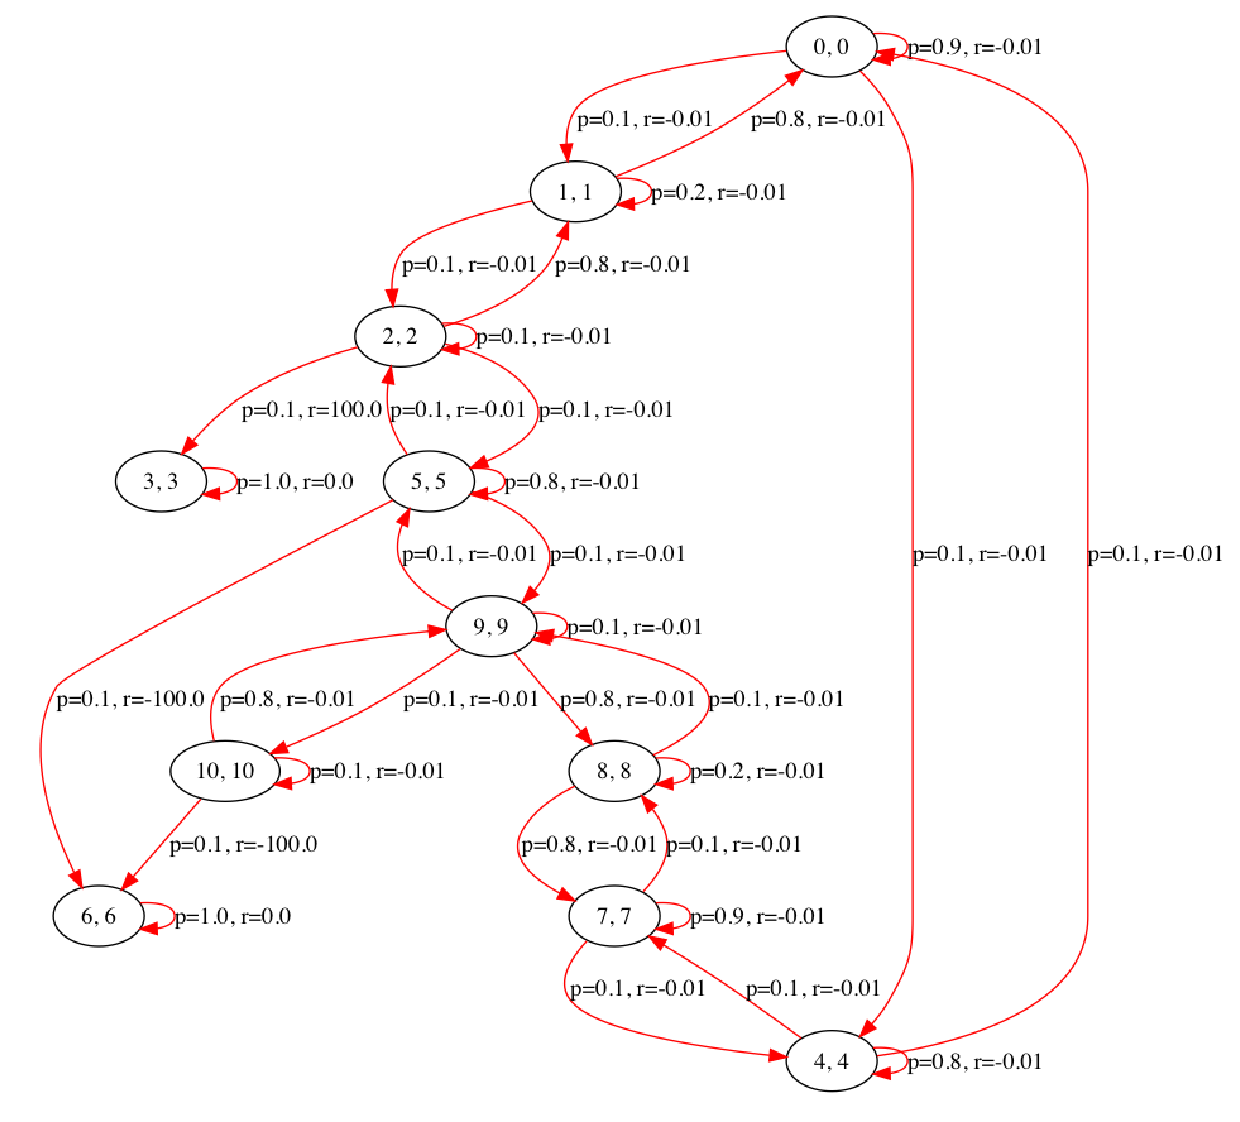

In [18]:
disp_mdp(mdp_descr, pi.V)

# MaxEntropy IRL

## Feature Expectations

In [75]:
def compute_feature_expectations(trajectories, state_idx_to_features, gamma=1.):
    
    """
    Computes and returns: μ(π) from trajectories
    The expectation is taken with respect to the random state sequence s0, s1, ... drawn by starting from a state s0 ∼ D, 
    and picking actions according to unknown π.
    
    Input:
        trajectories: 3D numpy matrix of size M x T x 3, where M is number of trajectories, 
                        T is fixed length of the trajectory (padded with last state if terminated early), 3 is for (s, a, r)
        state_idx_to_features: 2D numpy matrix mapping state index to its features of size N x K, 
                        N is total # of known states and K is its feature dimensionality
    """
    feature_expectations = np.zeros(state_idx_to_features.shape[1])
    for trajectory in trajectories:
        for i, (s_idx, a_idx, _) in enumerate(trajectory): # we ignore rewards because that's assumed to be unknown
            feature_i = state_idx_to_features[s_idx]
            # Assuming R is a linear combination of known features of the state s, R(s) = w . Phi(s)
            feature_expectations += (gamma**i)*feature_i
    
    return feature_expectations / trajectories.shape[0]


In [76]:
gw = GridWorld(book_grid, gamma=1.)
trajectories_mat = np.asarray(gw.sample_trajectories(1000, max_length=5), dtype=np.int)

In [77]:
compute_feature_expectations(trajectories_mat, gw.get_state_features_matrix(), gamma=gw.gamma)

array([ 4.491, 10.568])

## State Visitation Frequency
Forward pass

In [119]:
def compute_state_visitation_frequency(trajectories, nS, nA, dynamics_T, policy):
    """
    Computes state visitation frequency using forward algorith, uses DP algorithm from Zeibart et. al (2008).
    
    p(s, t+1) = sum_s' sum_a ( p(s', t-1) * p(a|s') * p(s|s', a))
    i.e., Prob. of being in state at time t+1 = sum over all prev state and actions ( 
                                            probability of being in prev state at time t-1 * probability of taking action a in prev state 
                                            * transition dynamics (state | prev state, action))
    The problem is we don't know p(s) at any time, so we start from p(s0) which can be easily computed from seeing first state of trajectories
    and dividing by number of trajectories (M). Once we have p(s,0) for all s, we can build up p(s,t) using DP. Iteratively compute p(s,t+1) 
    from previously computed p(s, t-1), all we need is policy that affects the state evolution along with dynamics for stochastic actions.  
    
    Ref: DPV chapter 7 on DP to learn more about DP
    """
    
    # svf for unvisited state is 0 so we'll only use states from the trajectory
    
    M, T, _ = trajectories.shape
    state_idxs = range(nS)
    action_idxs = range(nA)
    
    init_state_idxs = trajectories[:,0,0] # take first visited state from all trajectories
    t0_visitation_count, _ = np.histogram(init_state_idxs, bins=range(nS+1))
    mu_0_s = t0_visitation_count / float(M) # mu_0_s = p(s0 = s), consider s1 and mu_1 if you're a 1 based indexing fan
    
    mu_t_s = np.zeros((T, nS))
    mu_t_s[0, :] = mu_0_s
    
    for t in range(1,T):
        for s_idx in state_idxs:
            for a_idx in action_idxs:
                for s_prime_idx in state_idxs:
                    mu_t_s[t, s_idx] += mu_t_s[t-1, s_prime_idx] * policy[s_prime_idx] * dynamics_T[s_idx, a_idx, s_prime_idx]
    return mu_t_s.sum(axis=0)

In [124]:
# compute_state_visitation_frequency(trajectories_mat, gw.nS, gw.nA, gw.get_transition_dynamics_T(), gw.get_optimal_policy())

## Reference

1. Ziebart, Brian D., et al. "Maximum Entropy Inverse Reinforcement Learning." AAAI. Vol. 8. 2008.
2. Matthew Alger's MaxEnt implementation. https://github.com/MatthewJA/Inverse-Reinforcement-Learning/blob/master/irl/maxent.py